In [115]:
#Data import and manipulation
import numpy as np
import pandas as pd

#For Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Splitting and modelling the dataset
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import warnings
warnings.filterwarnings('ignore')

In [35]:
df = pd.read_csv('./Copy of bank-full.csv', sep=";")
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [36]:
df.shape

(45211, 17)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [38]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


## Data Health Checkup

In [39]:
df.isnull().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

In [40]:
df.duplicated().sum()

0

In [41]:
categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
numerical_cols = df.select_dtypes(include = ['float64', 'int64']).columns.tolist()

In [42]:
for col in categorical_cols:
    print(col)
    print(df[col].value_counts(normalize=True))
    print('--------------------------')

job
blue-collar      0.215257
management       0.209197
technician       0.168034
admin.           0.114375
services         0.091880
retired          0.050076
self-employed    0.034925
entrepreneur     0.032890
unemployed       0.028820
housemaid        0.027427
student          0.020747
unknown          0.006370
Name: job, dtype: float64
--------------------------
marital
married     0.601933
single      0.282896
divorced    0.115171
Name: marital, dtype: float64
--------------------------
education
secondary    0.513194
tertiary     0.294198
primary      0.151534
unknown      0.041074
Name: education, dtype: float64
--------------------------
default
no     0.981973
yes    0.018027
Name: default, dtype: float64
--------------------------
housing
yes    0.555838
no     0.444162
Name: housing, dtype: float64
--------------------------
loan
no     0.839774
yes    0.160226
Name: loan, dtype: float64
--------------------------
contact
cellular     0.647741
unknown      0.287983
telephone

In [43]:
df['contact'] = df['contact'].replace(to_replace=['cellular', 'telephone'], value='phone')

In [44]:
mapper = {'jan': 1, 'feb': 2, 'mar': 3,'apr': 4,'may': 5,'jun': 6,'jul': 7,'aug': 8,'sep': 9,'oct': 10,'nov': 11,'dec': 12}
df.replace({'month': mapper}, inplace=True)

# Observations

1. Most of the columns have fine distributions except default which is heavily biased towards values of no. We can drop it after analyzing its impact on the target.
2. We have atleast 60% people who are married
3. We have atleast 51% people who completed their secondary education
4. Most of the people in the dataset are coming from good job backgrounds i.e. blue collar or management
5. We have 2 similar categories i.e. cellular and telephone within contact. We can combine them into 1 category if they have similar impact on target as well.

# Univariate Analysis

In [45]:
def univariate_analysis(data, feature, figsize=(8,5), bins=10, kde=False):
    f2, ax_hist = plt.subplots(nrows=1, figsize=figsize)
    
    sns.histplot(data=data, x=feature, ax=ax_hist, bins=bins)
    ax_hist.axvline(data[feature].mean(), color='green', linestyle="--")
    ax_hist.axvline(data[feature].median(), color='black', linestyle="--")

In [46]:
num_plot = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [47]:
num_plot

['age', 'balance', 'day', 'month', 'duration', 'campaign', 'pdays', 'previous']

In [48]:
num_plot.remove('day')

In [49]:
num_plot

['age', 'balance', 'month', 'duration', 'campaign', 'pdays', 'previous']

In [50]:
numerical_cols

['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

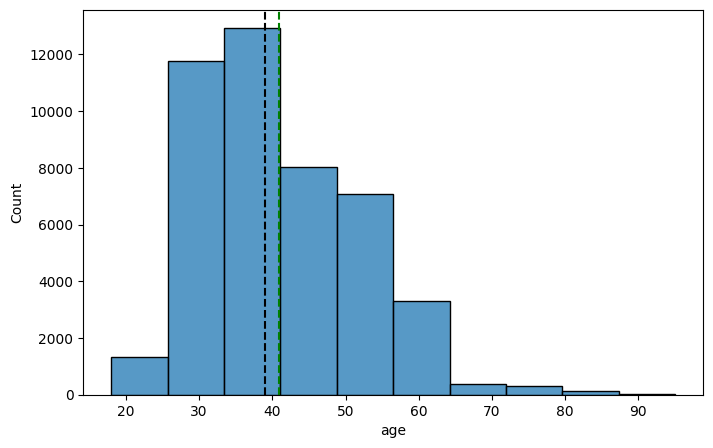

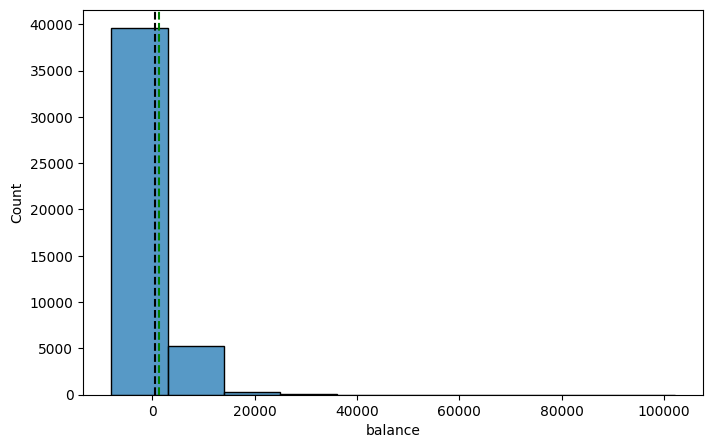

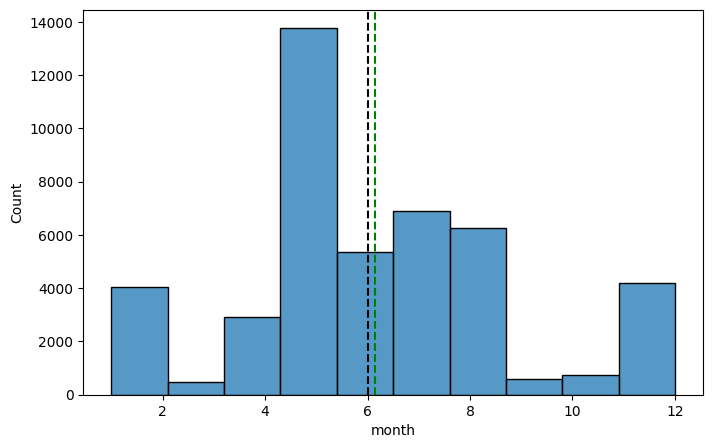

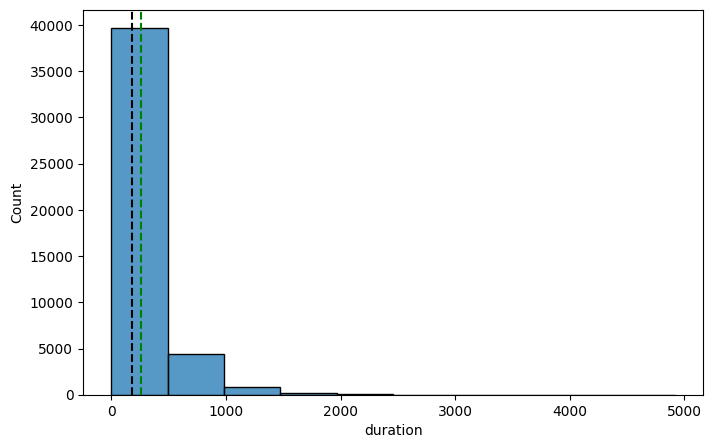

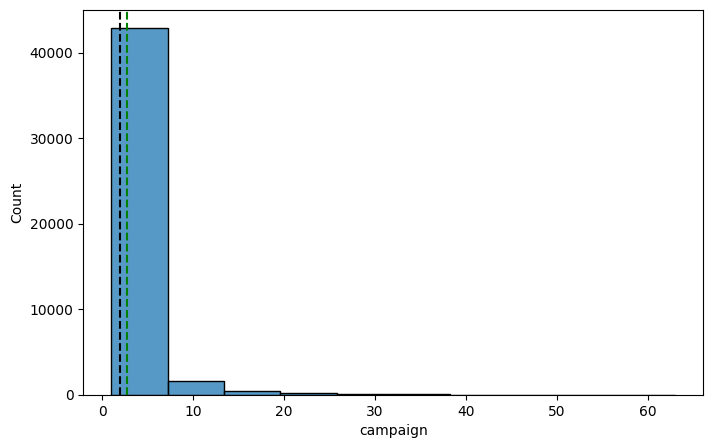

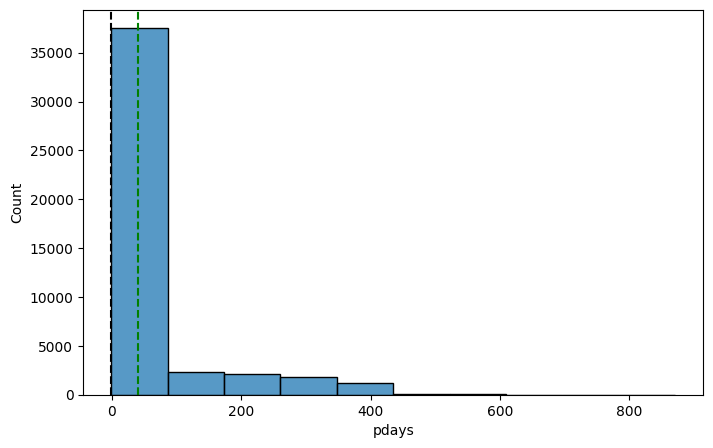

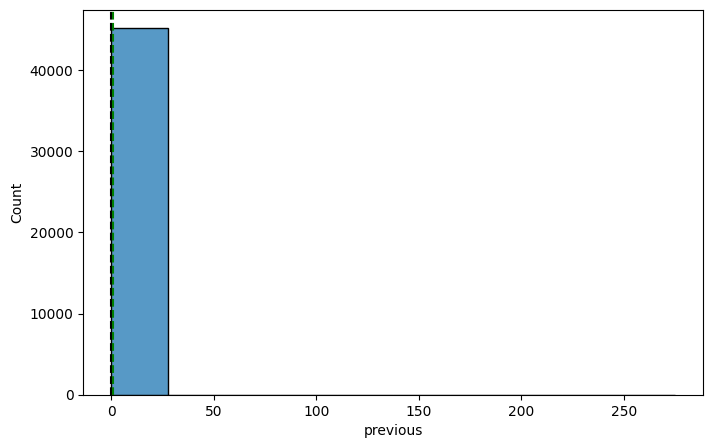

In [51]:
for col in num_plot:
    univariate_analysis(df, col)

# Bivariate Analysis

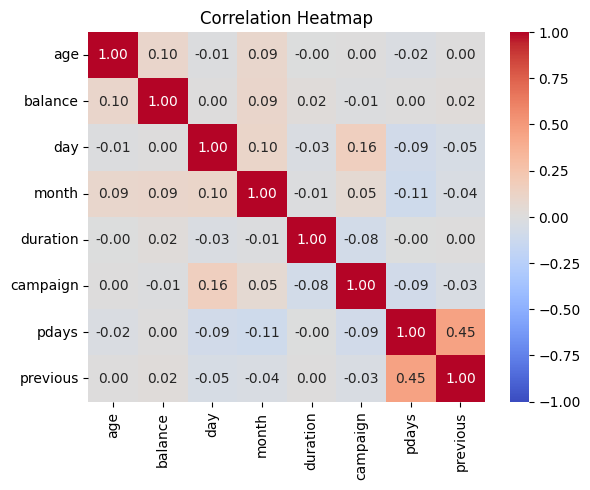

In [52]:
corrs = df.corr()

sns.heatmap(corrs, annot=True, vmin=-1, vmax=1, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

 #### Numerical Columns

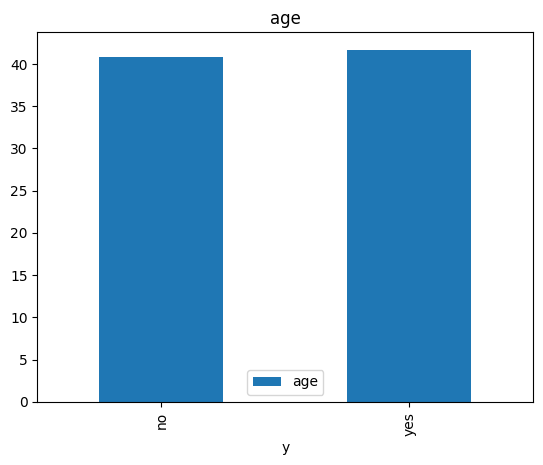

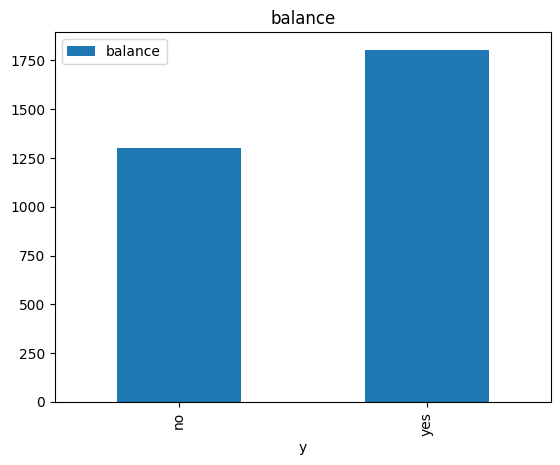

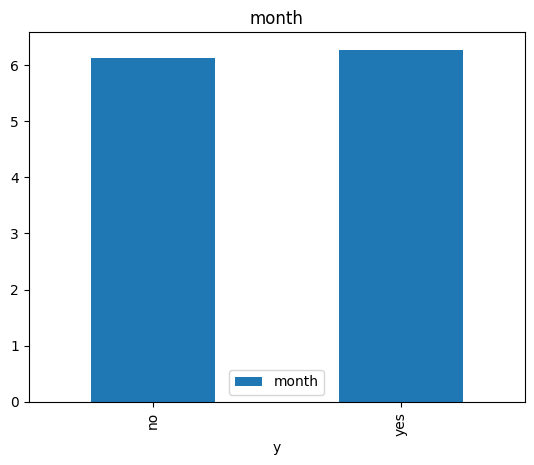

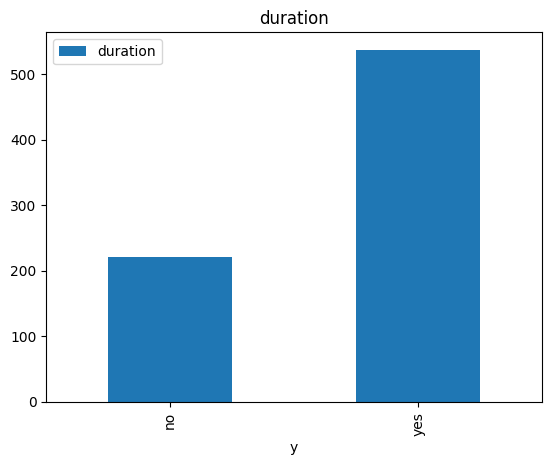

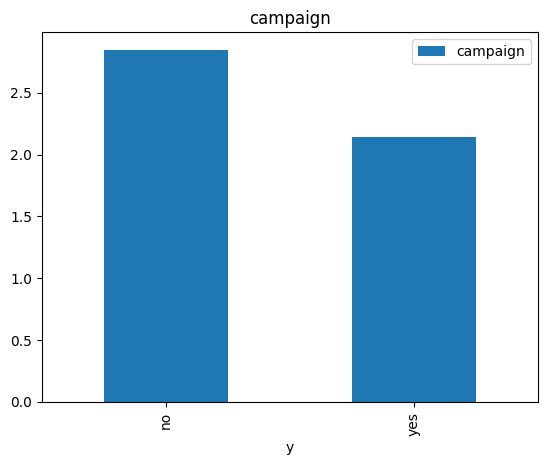

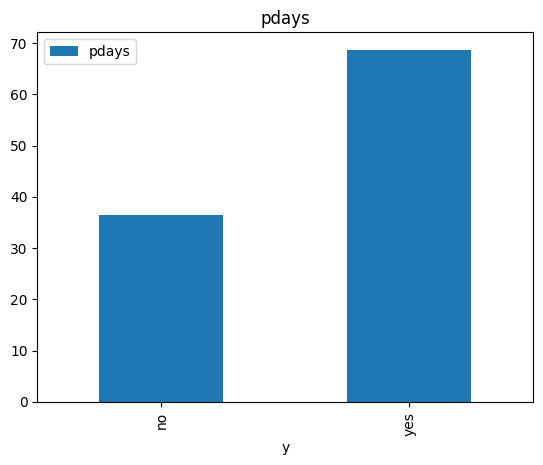

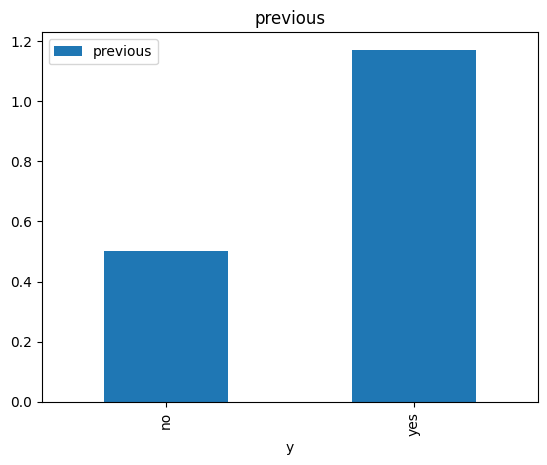

In [53]:
for col in num_plot:
    df.pivot_table(index='y', values= col, aggfunc='mean').plot(kind='bar')
    plt.title(col)

#### Categorical Columns

In [54]:
categorical_cols.remove('y')

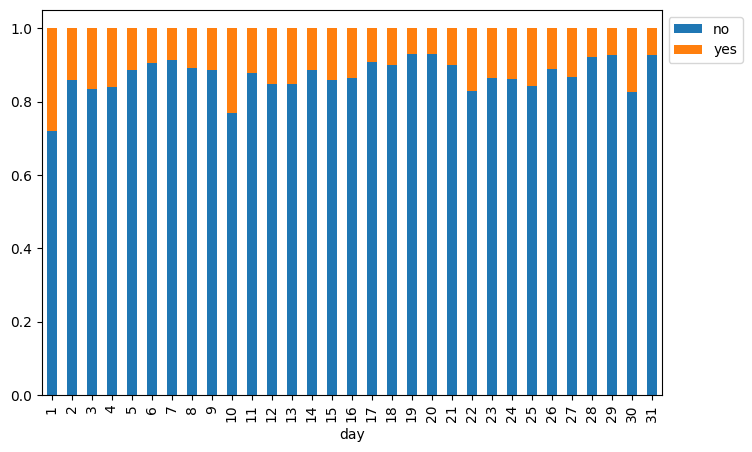

In [55]:
summ = pd.crosstab(df['day'], df['y'], normalize='index')
summ.plot(kind='bar', stacked=True, figsize=(8,5))
plt.legend(loc='upper left', bbox_to_anchor=(1,1))
plt.show()

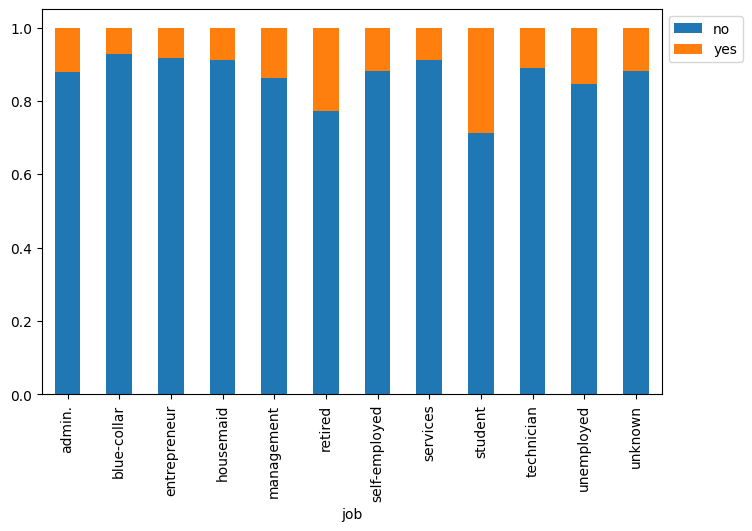

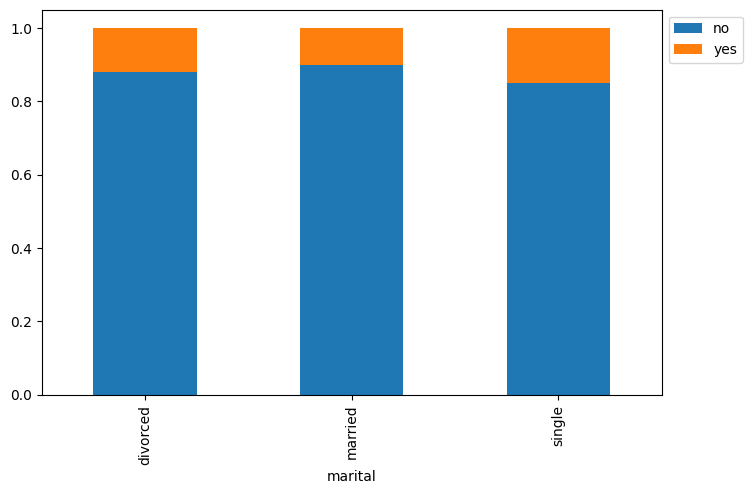

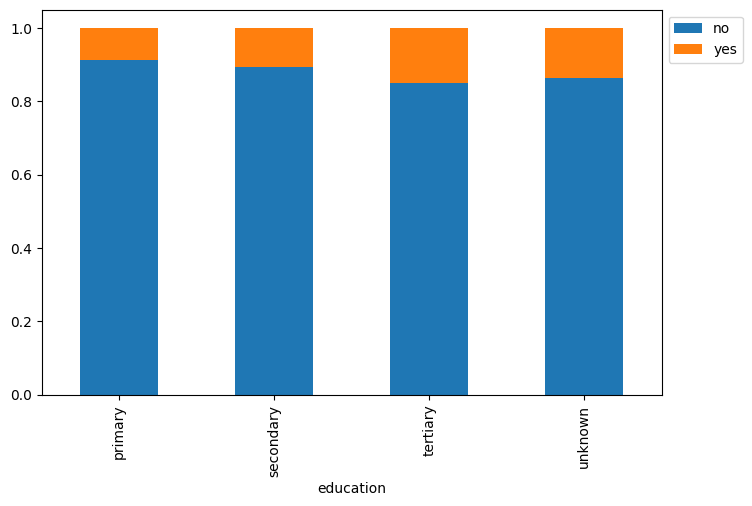

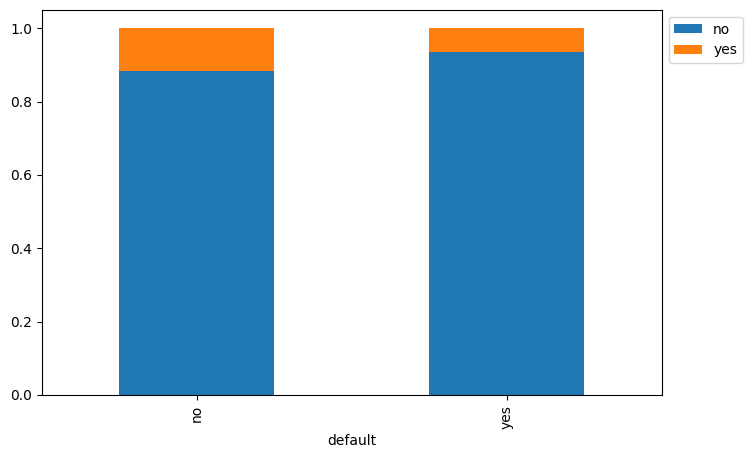

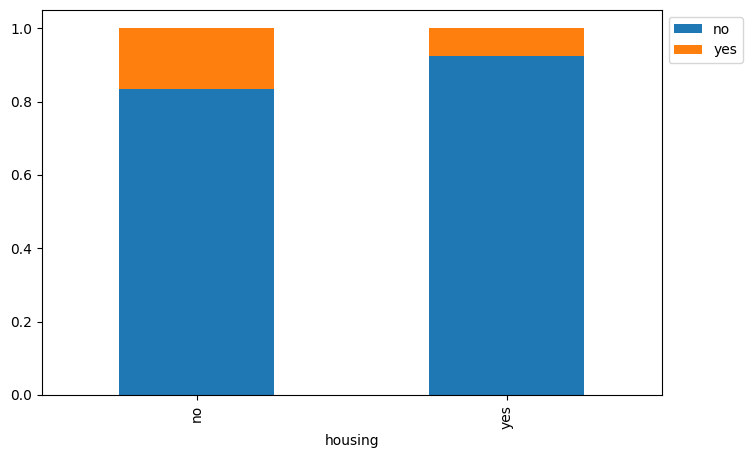

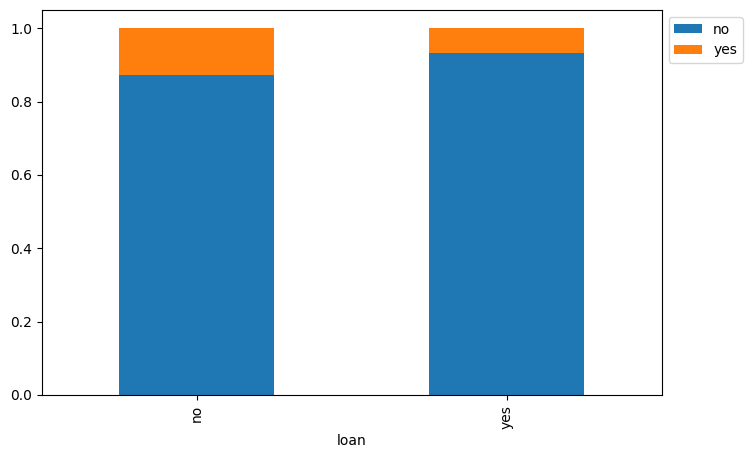

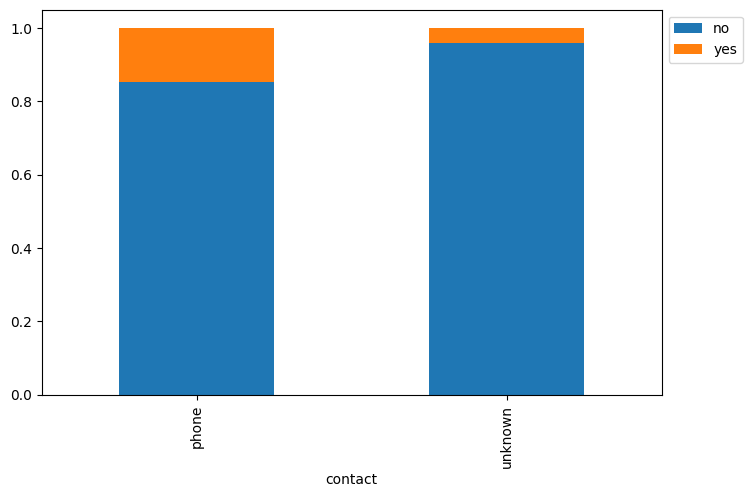

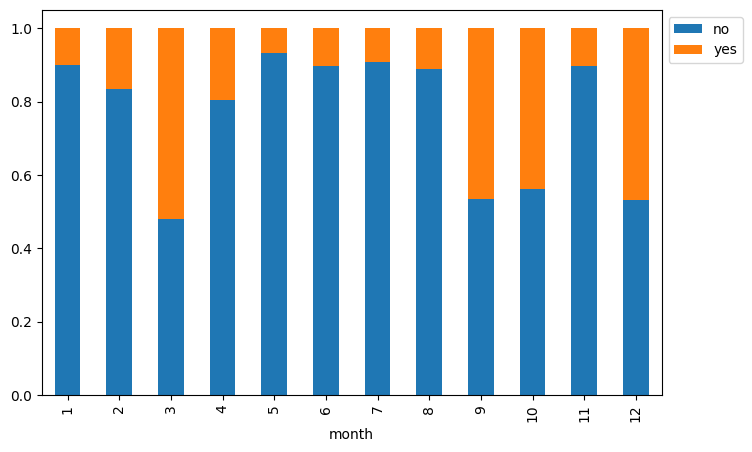

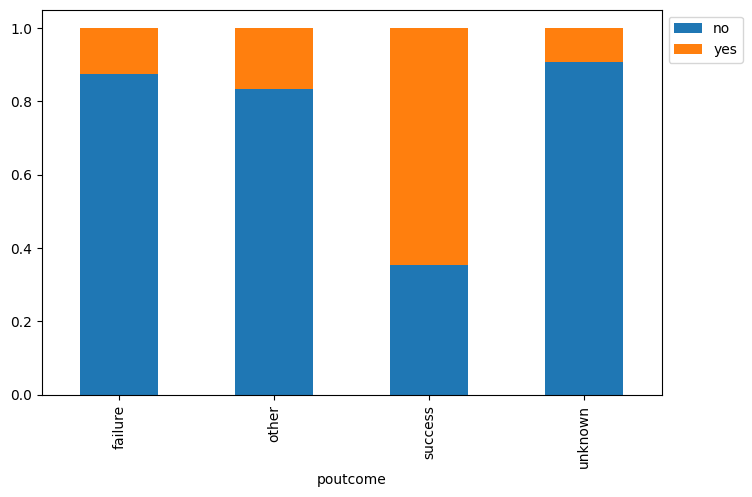

In [56]:
for col in categorical_cols:
    summ = pd.crosstab(df[col], df['y'], normalize='index')
    summ.plot(kind='bar', stacked=True, figsize=(8,5))
    plt.legend(loc='upper left', bbox_to_anchor=(1,1))
    plt.show()

# Observations
1. Every 10 days we can see a good amount of people take term deposits
2. Retired and Student have a higher chance to choose term deposits
3. People who have not taken a housing personal loan have a high chance to take term deopsit
4. Also the people who have not taken any personal loan are seen to take term deposit
5. cellular and telephone calls are found to be a good option for conversion rate
6. The largest conversion are found during month of March, September, October and December

In [57]:
df['y'] = df['y'].map({"yes":1, "no":0})

In [58]:
categorical_cols.remove('default')
categorical_cols.remove('month')

categorical_cols

['job', 'marital', 'education', 'housing', 'loan', 'contact', 'poutcome']

## Observation:
Month is already converted into label encoding and default have a high percentage of no i.e. 0 so anyhow we going to drop that variable

In [59]:
df.drop(columns = 'default', inplace=True)

In [60]:
# categorizing the categorical variables and droping first variable to remove multicollinearity
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [61]:
df.head()

,age,balance,day,month,duration,campaign,pdays,previous,y,job_blue-collar,...,marital_single,education_secondary,education_tertiary,education_unknown,housing_yes,loan_yes,contact_unknown,poutcome_other,poutcome_success,poutcome_unknown
0,58,2143,5,5,261,1,-1,0,0,0,...,0,0,1,0,1,0,1,0,0,1
1,44,29,5,5,151,1,-1,0,0,0,...,1,1,0,0,1,0,1,0,0,1
2,33,2,5,5,76,1,-1,0,0,0,...,0,1,0,0,1,1,1,0,0,1
3,47,1506,5,5,92,1,-1,0,0,1,...,0,0,0,1,1,0,1,0,0,1
4,33,1,5,5,198,1,-1,0,0,0,...,1,0,0,1,0,0,1,0,0,1


## Train Test Split

In [29]:
X = df.drop(['y'], axis = 1)
y = df['y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

In [30]:
# Analyze the output from train and test data
print(f'Shape of training set : {X_train.shape}')
print(f'Shape of test set : {X_test.shape}')

print('Percentage of classes in training set:')
print(y_train.value_counts(normalize=True))

print('Percentage of classes in test set:')
print(y_test.value_counts(normalize=True))

Shape of training set : (31647, 30)
Shape of test set : (13564, 30)
Percentage of classes in training set:
0    0.88337
1    0.11663
Name: y, dtype: float64
Percentage of classes in test set:
0    0.882188
1    0.117812
Name: y, dtype: float64


# Model Fitting 

### Metrics that needs to be chosen

We will work with recall score which will be suitable metrics to identify the people who have opted for term deposit since not identifying them will be a loss of opportunity for the bank.

## Using Random Forest

In [62]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

rf_model.score(X_train, y_train)

0.9999684014282555

In [63]:
rf_model.score(X_test, y_test)

0.9029784724270127

In [64]:
print(classification_report(y_train, rf_model.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27956
           1       1.00      1.00      1.00      3691

    accuracy                           1.00     31647
   macro avg       1.00      1.00      1.00     31647
weighted avg       1.00      1.00      1.00     31647



In [65]:
print(classification_report(y_test, rf_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.65      0.38      0.48      1598

    accuracy                           0.90     13564
   macro avg       0.79      0.68      0.71     13564
weighted avg       0.89      0.90      0.89     13564



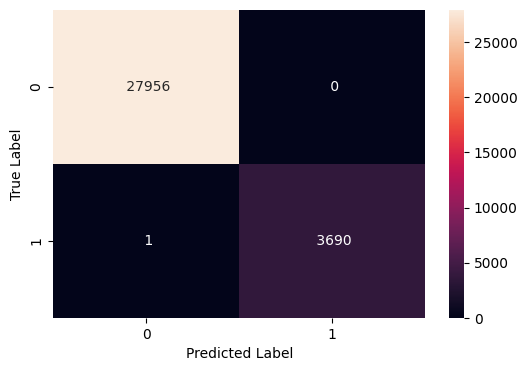

In [66]:
# Confusion Matrix of Training Data using Random Forest

cm = confusion_matrix(y_train, rf_model.predict(X_train))

labels = np.asarray(
    [
        ["{0: 0.0f}".format(item)]
        for item in cm.flatten()
    ]
).reshape(2,2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt="")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

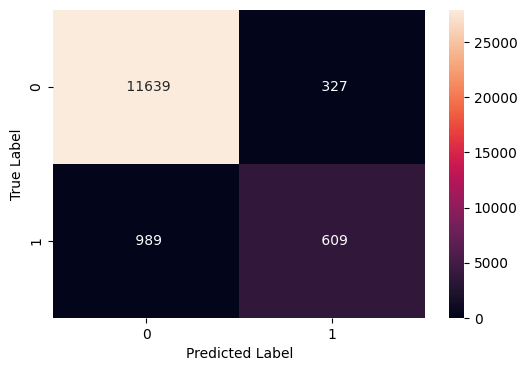

In [67]:
# Confusion Matrix of Testing Data using Random Forest

cm1 = confusion_matrix(y_test, rf_model.predict(X_test))

labels = np.asarray(
    [
        ["{0: 0.0f}".format(item)]
        for item in cm1.flatten()
    ]
).reshape(2,2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt="")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Observations

We are clearly seeing overfitting in Random Forest by default. The recall score is dropping to 38% in test data as compared to 100% in train data

This proves that bagging doesn't automatically make the model varince proof. We still have to perform certain steps to fight the overfitting

## Using Gradient Bossting

In [68]:
gb_model = GradientBoostingClassifier()
gb_model.fit(X_train, y_train)

gb_model.score(X_train, y_train)

0.9116187948304737

In [69]:
gb_model.score(X_test, y_test)

0.903347095252138

In [70]:
# Classification Report using Gradient Boosting of Trained Data

print(classification_report(y_train, gb_model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.93      0.97      0.95     27956
           1       0.69      0.44      0.54      3691

    accuracy                           0.91     31647
   macro avg       0.81      0.71      0.74     31647
weighted avg       0.90      0.91      0.90     31647



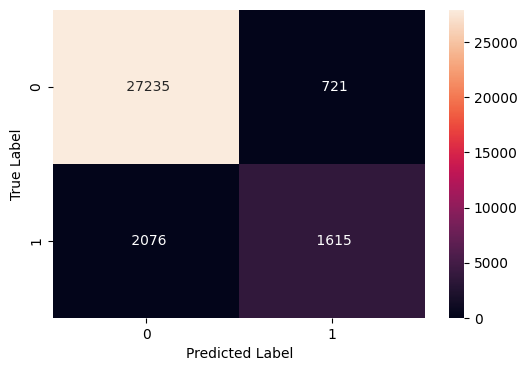

In [71]:
# Confusion Matrix of Training Data using Gradient Boosting

cm_gb_1 = confusion_matrix(y_train, gb_model.predict(X_train))

labels = np.asarray(
    [
        ["{0: 0.0f}".format(item)]
        for item in cm_gb_1.flatten()
    ]
).reshape(2,2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt="")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

In [72]:
# Classification Report using Gradient Boosting of Test Data

print(classification_report(y_test, gb_model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.92      0.97      0.95     11966
           1       0.64      0.40      0.49      1598

    accuracy                           0.90     13564
   macro avg       0.78      0.69      0.72     13564
weighted avg       0.89      0.90      0.89     13564



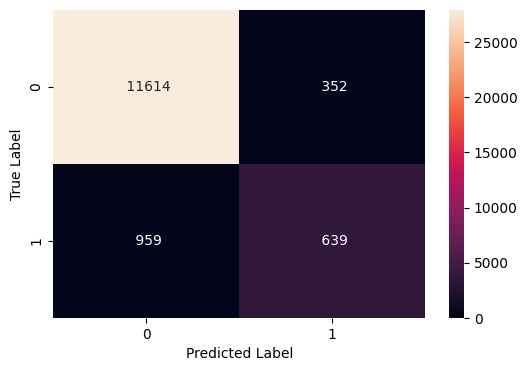

In [73]:
# Confusion Matrix of Test Data using Gradient Boosting

cm_gb_2 = confusion_matrix(y_test, gb_model.predict(X_test))

labels = np.asarray(
    [
        ["{0: 0.0f}".format(item)]
        for item in cm_gb_2.flatten()
    ]
).reshape(2,2)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=labels, fmt="")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

## Under Sampling with Random Forest and Gradient Boosting

In [74]:
rus = RandomUnderSampler(random_state=1, sampling_strategy=1) 
# sampling_strategy = 1 is used to make the ratio to majority class to minority as 1:1

X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

print("Before UnderSampling, counts of label '1': {}".format(sum(y_train == 1)))
print("Before UnderSampling, counts of label '0': {} \n".format(sum(y_train == 0)))

print("After UnderSampling, counts of label '1': {}".format(sum(y_train_un == 1)))
print("After UnderSampling, counts of label '0': {} \n".format(sum(y_train_un == 0)))

print("After UnderSampling, shape of x_train: {}".format(X_train_un.shape))
print("After UnderSampling, shape of y_train: {} \n".format(y_train_un.shape))

Before UnderSampling, counts of label '1': 3691
Before UnderSampling, counts of label '0': 27956 

After UnderSampling, counts of label '1': 3691
After UnderSampling, counts of label '0': 3691 

After UnderSampling, shape of x_train: (7382, 30)
After UnderSampling, shape of y_train: (7382,) 



# Random Forest with UnderSampled Data

In [76]:
rf_model_un = RandomForestClassifier()
rf_model_un.fit(X_train_un, y_train_un)

# Model Score
rf_model_un.score(X_train_un, y_train_un)

1.0

In [77]:
print(classification_report(y_train_un, rf_model_un.predict(X_train_un)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3691
           1       1.00      1.00      1.00      3691

    accuracy                           1.00      7382
   macro avg       1.00      1.00      1.00      7382
weighted avg       1.00      1.00      1.00      7382



In [78]:
print(classification_report(y_test, rf_model_un.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     11966
           1       0.41      0.87      0.56      1598

    accuracy                           0.84     13564
   macro avg       0.69      0.85      0.73     13564
weighted avg       0.91      0.84      0.86     13564



# Gradient Boosting with UnderSampled Data

In [79]:
gb_model_un = GradientBoostingClassifier()
gb_model_un.fit(X_train_un, y_train_un)

# Model Score
gb_model_un.score(X_train_un, y_train_un)

0.8664318612842048

In [80]:
print(classification_report(y_train_un, gb_model_un.predict(X_train_un)))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3691
           1       0.85      0.89      0.87      3691

    accuracy                           0.87      7382
   macro avg       0.87      0.87      0.87      7382
weighted avg       0.87      0.87      0.87      7382



In [81]:
print(classification_report(y_test, gb_model_un.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     11966
           1       0.41      0.87      0.55      1598

    accuracy                           0.84     13564
   macro avg       0.69      0.85      0.73     13564
weighted avg       0.91      0.84      0.86     13564



# OverSampling with Random Forest and Gradient Boosting

In [82]:
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1) # Synthetic Minority Over Sampling Technique
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

print("Before OverSampling, counts of label 'Yes': {}".format(sum(y_train == 1)))
print("Before OverSampling, counts of label 'No': {} \n".format(sum(y_train == 0)))

print("After OverSampling, counts of label 'Yes': {}".format(sum(y_train_over == 1)))
print("After OverSampling, counts of label 'No': {} \n".format(sum(y_train_over == 0)))


print("After OverSampling, the shape of x_train: {}".format(X_train_over.shape))
print("After OverSampling, the shape of y_train: {} \n".format(y_train_over.shape))

Before OverSampling, counts of label 'Yes': 3691
Before OverSampling, counts of label 'No': 27956 

After OverSampling, counts of label 'Yes': 27956
After OverSampling, counts of label 'No': 27956 

After OverSampling, the shape of x_train: (55912, 30)
After OverSampling, the shape of y_train: (55912,) 



# Random Forest with OverSampled Data

In [83]:
rf_model_over = RandomForestClassifier()
rf_model_over.fit(X_train_over, y_train_over)

rf_model_over.score(X_train_over, y_train_over)

1.0

In [84]:
print(classification_report(y_train_over, rf_model_over.predict(X_train_over)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27956
           1       1.00      1.00      1.00     27956

    accuracy                           1.00     55912
   macro avg       1.00      1.00      1.00     55912
weighted avg       1.00      1.00      1.00     55912



In [85]:
print(classification_report(y_test, rf_model_over.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94     11966
           1       0.54      0.52      0.53      1598

    accuracy                           0.89     13564
   macro avg       0.74      0.73      0.74     13564
weighted avg       0.89      0.89      0.89     13564



# Gradient Boosting with OverSampled Data

In [86]:
gb_model_over = GradientBoostingClassifier()
gb_model_over.fit(X_train_over, y_train_over)

gb_model_over.score(X_train_over, y_train_over)

0.9224137931034483

In [87]:
print(classification_report(y_train_over, gb_model_over.predict(X_train_over)))

              precision    recall  f1-score   support

           0       0.93      0.91      0.92     27956
           1       0.91      0.93      0.92     27956

    accuracy                           0.92     55912
   macro avg       0.92      0.92      0.92     55912
weighted avg       0.92      0.92      0.92     55912



In [88]:
print(classification_report(y_test, gb_model_over.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.91      0.93     11966
           1       0.48      0.65      0.55      1598

    accuracy                           0.88     13564
   macro avg       0.72      0.78      0.74     13564
weighted avg       0.90      0.88      0.88     13564



# Observations

1. Under Sampling seems to have improved performance in both random forest and gradient boosting machines(in recall).
2. Over Sampling still seems to have overfitting in both random forest and gradient boosting machines(in recall).

# Random Forest With HyperParameter Tuning

In [96]:
from sklearn import metrics

In [97]:
# Choose the type of classifier
rf_tuned = RandomForestClassifier(random_state=1)

#Grid of paramter to choose from
parameters = {
    "max_depth": [4, 6, 8, 10, None],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [80, 90, 100, 110, 120]
}

scorer = metrics.make_scorer(metrics.recall_score)

# Run the Randomized search
random_obj = RandomizedSearchCV(rf_tuned, parameters, scoring = scorer, cv = 3, n_iter = 50, verbose=2)
random_obj = random_obj.fit(X_train, y_train)

# Set the clf to the best combination of parameter
rf_tuned0 = random_obj.best_estimator_

#Fit the best estimator to the data
rf_tuned0.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END ...max_depth=6, max_features=None, n_estimators=110; total time=   6.2s
[CV] END ...max_depth=6, max_features=None, n_estimators=110; total time=   5.3s
[CV] END ...max_depth=6, max_features=None, n_estimators=110; total time=   5.6s
[CV] END ...max_depth=4, max_features=sqrt, n_estimators=120; total time=   1.4s
[CV] END ...max_depth=4, max_features=sqrt, n_estimators=120; total time=   1.5s
[CV] END ...max_depth=4, max_features=sqrt, n_estimators=120; total time=   1.5s
[CV] END ....max_depth=8, max_features=log2, n_estimators=90; total time=   1.4s
[CV] END ....max_depth=8, max_features=log2, n_estimators=90; total time=   1.7s
[CV] END ....max_depth=8, max_features=log2, n_estimators=90; total time=   1.3s
[CV] END ...max_depth=6, max_features=log2, n_estimators=120; total time=   1.4s
[CV] END ...max_depth=6, max_features=log2, n_estimators=120; total time=   1.7s
[CV] END ...max_depth=6, max_features=log2, n_e

[CV] END ....max_depth=8, max_features=None, n_estimators=80; total time=   5.0s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=90; total time=   2.9s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=90; total time=   3.2s
[CV] END .max_depth=None, max_features=sqrt, n_estimators=90; total time=   2.8s
[CV] END ....max_depth=4, max_features=log2, n_estimators=90; total time=   0.8s
[CV] END ....max_depth=4, max_features=log2, n_estimators=90; total time=   0.8s
[CV] END ....max_depth=4, max_features=log2, n_estimators=90; total time=   0.7s
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  16.0s
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  15.4s
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  15.3s
[CV] END ...max_depth=6, max_features=None, n_estimators=100; total time=   4.7s
[CV] END ...max_depth=6, max_features=None, n_estimators=100; total time=   5.4s
[CV] END ...max_depth=6, max

RandomForestClassifier(max_features=None, random_state=1)

In [98]:
print(classification_report(y_train, rf_tuned0.predict(X_train)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27956
           1       1.00      1.00      1.00      3691

    accuracy                           1.00     31647
   macro avg       1.00      1.00      1.00     31647
weighted avg       1.00      1.00      1.00     31647



In [100]:
print(classification_report(y_test, rf_tuned0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     11966
           1       0.62      0.46      0.53      1598

    accuracy                           0.90     13564
   macro avg       0.77      0.71      0.74     13564
weighted avg       0.89      0.90      0.90     13564



# Gradient Boosting with HyperParameter Tuning

In [102]:
# Choose the type of classifier
gb_tuned = GradientBoostingClassifier(random_state=1)

#Grid of paramter to choose from
parameters = {
    "n_estimators": np.arange(50,200,25),
    "learning_rate": np.arange(0.001, 0.1, 0.001),
    "subsample": [0.7, 0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9, 1],
    "max_depth": [3, 5, 7, 10]
}

scorer = metrics.make_scorer(metrics.recall_score)

# Run the Randomized search
random_obj1 = RandomizedSearchCV(gb_tuned, parameters, scoring = scorer, cv = 3, n_iter = 50, verbose = 2)
random_obj1.fit(X_train, y_train)

# Set the clf to the best combination of parameter
gb_tuned0 = random_obj1.best_estimator_

#Fit the best estimator to the data
gb_tuned0.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.7, n_estimators=50, subsample=1; total time=   1.8s
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.7, n_estimators=50, subsample=1; total time=   1.6s
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.7, n_estimators=50, subsample=1; total time=   1.9s
[CV] END learning_rate=0.08700000000000001, max_depth=7, max_features=0.7, n_estimators=175, subsample=0.9; total time=  14.0s
[CV] END learning_rate=0.08700000000000001, max_depth=7, max_features=0.7, n_estimators=175, subsample=0.9; total time=  12.8s
[CV] END learning_rate=0.08700000000000001, max_depth=7, max_features=0.7, n_estimators=175, subsample=0.9; total time=  12.2s
[CV] END learning_rate=0.062, max_depth=10, max_features=0.9, n_estimators=175, subsample=0.7; total time=  20.2s
[CV] END learning_rate=0.062, max_depth=10, max_features=0.9, n_esti

[CV] END learning_rate=0.003, max_depth=3, max_features=1, n_estimators=150, subsample=1; total time=   1.0s
[CV] END learning_rate=0.008, max_depth=5, max_features=0.9, n_estimators=50, subsample=0.8; total time=   2.9s
[CV] END learning_rate=0.008, max_depth=5, max_features=0.9, n_estimators=50, subsample=0.8; total time=   3.0s
[CV] END learning_rate=0.008, max_depth=5, max_features=0.9, n_estimators=50, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.021, max_depth=7, max_features=1, n_estimators=75, subsample=0.7; total time=   1.1s
[CV] END learning_rate=0.021, max_depth=7, max_features=1, n_estimators=75, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.021, max_depth=7, max_features=1, n_estimators=75, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.027000000000000003, max_depth=3, max_features=0.7, n_estimators=50, subsample=1; total time=   1.3s
[CV] END learning_rate=0.027000000000000003, max_depth=3, max_features=0.7, n_estimators=50, subsamp

[CV] END learning_rate=0.07200000000000001, max_depth=7, max_features=0.7, n_estimators=50, subsample=0.7; total time=   3.1s
[CV] END learning_rate=0.048, max_depth=10, max_features=1, n_estimators=50, subsample=0.8; total time=   2.6s
[CV] END learning_rate=0.048, max_depth=10, max_features=1, n_estimators=50, subsample=0.8; total time=   2.1s
[CV] END learning_rate=0.048, max_depth=10, max_features=1, n_estimators=50, subsample=0.8; total time=   2.0s
[CV] END learning_rate=0.058, max_depth=7, max_features=1, n_estimators=50, subsample=0.9; total time=   0.8s
[CV] END learning_rate=0.058, max_depth=7, max_features=1, n_estimators=50, subsample=0.9; total time=   0.7s
[CV] END learning_rate=0.058, max_depth=7, max_features=1, n_estimators=50, subsample=0.9; total time=   0.8s


GradientBoostingClassifier(learning_rate=0.08700000000000001, max_depth=7,
                           max_features=0.7, n_estimators=175, random_state=1,
                           subsample=0.9)

In [103]:
print(classification_report(y_train, gb_tuned0.predict(X_train)))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98     27956
           1       0.94      0.76      0.84      3691

    accuracy                           0.97     31647
   macro avg       0.96      0.88      0.91     31647
weighted avg       0.97      0.97      0.97     31647



In [104]:
print(classification_report(y_test, gb_tuned0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.93      0.96      0.95     11966
           1       0.63      0.50      0.56      1598

    accuracy                           0.91     13564
   macro avg       0.78      0.73      0.75     13564
weighted avg       0.90      0.91      0.90     13564



# Random Forest with HyperParameter for OverSampled Data

In [109]:
rf_tuned_un = RandomForestClassifier(random_state=1)

parameters = {
    "max_depth": [4, 6, 8, 10, None],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [80, 90, 100, 110, 120]
}
scorer = metrics.make_scorer(metrics.recall_score)

rand_obj_rf = RandomizedSearchCV(rf_tuned_un, parameters, scoring = scorer, cv = 3, n_iter = 50,verbose = 2)
rand_obj_rf = rand_obj_rf.fit(X_train_over, y_train_over)

rf_tuned_un0 = rand_obj_rf.best_estimator_

rf_tuned_un0.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  26.9s
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  29.8s
[CV] END max_depth=None, max_features=None, n_estimators=120; total time=  37.3s
[CV] END max_depth=None, max_features=log2, n_estimators=110; total time=   5.4s
[CV] END max_depth=None, max_features=log2, n_estimators=110; total time=   6.8s
[CV] END max_depth=None, max_features=log2, n_estimators=110; total time=   7.1s
[CV] END max_depth=None, max_features=None, n_estimators=100; total time=  27.0s
[CV] END max_depth=None, max_features=None, n_estimators=100; total time=  30.3s
[CV] END max_depth=None, max_features=None, n_estimators=100; total time=  28.1s
[CV] END ....max_depth=4, max_features=sqrt, n_estimators=90; total time=   1.8s
[CV] END ....max_depth=4, max_features=sqrt, n_estimators=90; total time=   1.9s
[CV] END ....max_depth=4, max_features=sqrt, n_

[CV] END ..max_depth=10, max_features=log2, n_estimators=120; total time=   4.5s
[CV] END ...max_depth=6, max_features=sqrt, n_estimators=100; total time=   2.2s
[CV] END ...max_depth=6, max_features=sqrt, n_estimators=100; total time=   2.1s
[CV] END ...max_depth=6, max_features=sqrt, n_estimators=100; total time=   2.5s
[CV] END ..max_depth=10, max_features=None, n_estimators=100; total time=  15.3s
[CV] END ..max_depth=10, max_features=None, n_estimators=100; total time=  16.2s
[CV] END ..max_depth=10, max_features=None, n_estimators=100; total time=  16.1s
[CV] END ...max_depth=10, max_features=None, n_estimators=90; total time=  14.8s
[CV] END ...max_depth=10, max_features=None, n_estimators=90; total time=  16.0s
[CV] END ...max_depth=10, max_features=None, n_estimators=90; total time=  14.6s
[CV] END ...max_depth=8, max_features=None, n_estimators=100; total time=  23.7s
[CV] END ...max_depth=8, max_features=None, n_estimators=100; total time=  21.6s
[CV] END ...max_depth=8, max

RandomForestClassifier(max_depth=10, max_features='log2', n_estimators=110,
                       random_state=1)

In [110]:
print(classification_report(y_train_over, rf_tuned_un0.predict(X_train_over)))

              precision    recall  f1-score   support

           0       0.94      0.91      0.93     27956
           1       0.91      0.94      0.93     27956

    accuracy                           0.93     55912
   macro avg       0.93      0.93      0.93     55912
weighted avg       0.93      0.93      0.93     55912



In [111]:
print(classification_report(y_test, rf_tuned_un0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.90      0.92     11966
           1       0.46      0.65      0.54      1598

    accuracy                           0.87     13564
   macro avg       0.71      0.78      0.73     13564
weighted avg       0.89      0.87      0.88     13564



# Gradient Boosting with HyperParameter Tuning for OverSampled Data

In [168]:
gb_tuned_over = GradientBoostingClassifier(random_state=1)

parameters = {
    "n_estimators": np.arange(50, 200, 25),
    "learning_rate": np.arange(0.001, 0.1, 0.001),
    "subsample": [0.7, 0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9, 1],
    "max_depth": [3, 5, 7, 10]
}

scorer = metrics.make_scorer(metrics.recall_score)

rand_obj_gb = RandomizedSearchCV(gb_tuned_over, parameters, scoring = scorer, cv = 3,n_iter = 50, verbose = 2)
rand_obj_gb = rand_obj_gb.fit(X_train_over, y_train_over)

gb_tuned_over0 = rand_obj_gb.best_estimator_

gb_tuned_over0.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.056, max_depth=5, max_features=1, n_estimators=125, subsample=0.9; total time=   2.0s
[CV] END learning_rate=0.056, max_depth=5, max_features=1, n_estimators=125, subsample=0.9; total time=   2.1s
[CV] END learning_rate=0.056, max_depth=5, max_features=1, n_estimators=125, subsample=0.9; total time=   2.0s
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.9, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.9, n_estimators=100, subsample=0.8; total time=   6.7s
[CV] END learning_rate=0.014000000000000002, max_depth=3, max_features=0.9, n_estimators=100, subsample=0.8; total time=   6.0s
[CV] END learning_rate=0.04, max_depth=5, max_features=1, n_estimators=50, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.04, max_depth=5, max_features=1, n_estimators=50, subsample=0.7; total time=   1.1s
[CV

[CV] END learning_rate=0.036000000000000004, max_depth=5, max_features=0.9, n_estimators=50, subsample=1; total time=   5.5s
[CV] END learning_rate=0.05, max_depth=3, max_features=0.7, n_estimators=150, subsample=0.7; total time=   7.2s
[CV] END learning_rate=0.05, max_depth=3, max_features=0.7, n_estimators=150, subsample=0.7; total time=   7.1s
[CV] END learning_rate=0.05, max_depth=3, max_features=0.7, n_estimators=150, subsample=0.7; total time=   6.6s
[CV] END learning_rate=0.001, max_depth=10, max_features=1, n_estimators=125, subsample=0.7; total time=   8.5s
[CV] END learning_rate=0.001, max_depth=10, max_features=1, n_estimators=125, subsample=0.7; total time=   8.6s
[CV] END learning_rate=0.001, max_depth=10, max_features=1, n_estimators=125, subsample=0.7; total time=   8.2s
[CV] END learning_rate=0.003, max_depth=7, max_features=1, n_estimators=100, subsample=0.9; total time=   2.6s
[CV] END learning_rate=0.003, max_depth=7, max_features=1, n_estimators=100, subsample=0.9; 

[CV] END learning_rate=0.091, max_depth=3, max_features=0.7, n_estimators=50, subsample=0.8; total time=   2.5s
[CV] END learning_rate=0.091, max_depth=3, max_features=0.7, n_estimators=50, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.045, max_depth=7, max_features=0.7, n_estimators=125, subsample=0.9; total time=  16.0s
[CV] END learning_rate=0.045, max_depth=7, max_features=0.7, n_estimators=125, subsample=0.9; total time=  15.5s
[CV] END learning_rate=0.045, max_depth=7, max_features=0.7, n_estimators=125, subsample=0.9; total time=  15.5s
[CV] END learning_rate=0.077, max_depth=5, max_features=0.9, n_estimators=100, subsample=0.7; total time=   7.6s
[CV] END learning_rate=0.077, max_depth=5, max_features=0.9, n_estimators=100, subsample=0.7; total time=   9.1s
[CV] END learning_rate=0.077, max_depth=5, max_features=0.9, n_estimators=100, subsample=0.7; total time=   7.9s


GradientBoostingClassifier(learning_rate=0.021, max_depth=5, max_features=0.9,
                           n_estimators=50, random_state=1, subsample=0.7)

In [170]:
print(classification_report(y_train_over, gb_tuned_over0.predict(X_train_over)))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88     27956
           1       0.85      0.93      0.89     27956

    accuracy                           0.89     55912
   macro avg       0.89      0.89      0.89     55912
weighted avg       0.89      0.89      0.89     55912



In [171]:
print(classification_report(y_test, gb_tuned_over0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90     11966
           1       0.40      0.79      0.53      1598

    accuracy                           0.83     13564
   macro avg       0.68      0.82      0.71     13564
weighted avg       0.90      0.83      0.86     13564



# Random Forest with HyperParameter for UnderSampled Data

In [173]:
rf_tuned_unn = RandomForestClassifier(random_state=1)

parameters = {
    "max_depth": [4, 6, 8, 10, None],
    "max_features": ['sqrt', 'log2', None],
    "n_estimators": [80, 90, 100, 110, 120]
}
scorer = metrics.make_scorer(metrics.recall_score)

rand_obj_rf1 = RandomizedSearchCV(rf_tuned_unn, parameters, scoring = scorer, cv = 3, n_iter = 50,verbose = 1)
rand_obj_rf1 = rand_obj_rf1.fit(X_train_un, y_train_un)

rf_tuned_un1 = rand_obj_rf1.best_estimator_

rf_tuned_un1.fit(X_train_over, y_train_over)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


RandomForestClassifier(max_depth=10, max_features=None, n_estimators=110,
                       random_state=1)

In [174]:
print(classification_report(y_train_un, rf_tuned_un1.predict(X_train_un)))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      3691
           1       0.90      0.80      0.85      3691

    accuracy                           0.86      7382
   macro avg       0.86      0.86      0.85      7382
weighted avg       0.86      0.86      0.85      7382



In [175]:
print(classification_report(y_test, rf_tuned_un1.predict(X_test)))

              precision    recall  f1-score   support

           0       0.95      0.89      0.92     11966
           1       0.46      0.68      0.55      1598

    accuracy                           0.87     13564
   macro avg       0.71      0.79      0.73     13564
weighted avg       0.90      0.87      0.88     13564



# Gradient Boosting with HyperParameter for UnderSampled Data

In [178]:
gb_tuned_un = GradientBoostingClassifier(random_state=1)

parameters = {
    "n_estimators": np.arange(50, 200, 25),
    "learning_rate": np.arange(0.001, 0.1, 0.001),
    "subsample": [0.7, 0.8, 0.9, 1],
    "max_features": [0.7, 0.8, 0.9, 1],
    "max_depth": [3, 5, 7, 10]
}

scorer = metrics.make_scorer(metrics.recall_score)

rand_obj_gb1 = RandomizedSearchCV(gb_tuned_un, parameters, scoring = scorer, cv = 3,n_iter = 50, verbose = 2)
rand_obj_gb1 = rand_obj_gb1.fit(X_train_un, y_train_un)

gb_tuned_un0 = rand_obj_gb1.best_estimator_

gb_tuned_un0.fit(X_train_un, y_train_un)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END learning_rate=0.065, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.7; total time=   1.1s
[CV] END learning_rate=0.065, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.7; total time=   1.2s
[CV] END learning_rate=0.065, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.7; total time=   1.3s
[CV] END learning_rate=0.012, max_depth=10, max_features=0.9, n_estimators=100, subsample=0.8; total time=   4.2s
[CV] END learning_rate=0.012, max_depth=10, max_features=0.9, n_estimators=100, subsample=0.8; total time=   4.7s
[CV] END learning_rate=0.012, max_depth=10, max_features=0.9, n_estimators=100, subsample=0.8; total time=   4.4s
[CV] END learning_rate=0.033, max_depth=7, max_features=0.7, n_estimators=125, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.033, max_depth=7, max_features=0.7, n_estimators=125, subsample=0.8; total time=   2.2s
[CV] END learning_rate=0.033, max_

[CV] END learning_rate=0.012, max_depth=10, max_features=0.8, n_estimators=50, subsample=0.8; total time=   2.3s
[CV] END learning_rate=0.047, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.2s
[CV] END learning_rate=0.047, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.047, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.2s
[CV] END learning_rate=0.012, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.012, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.1s
[CV] END learning_rate=0.012, max_depth=5, max_features=0.9, n_estimators=75, subsample=0.8; total time=   1.0s
[CV] END learning_rate=0.092, max_depth=3, max_features=1, n_estimators=175, subsample=1; total time=   0.3s
[CV] END learning_rate=0.092, max_depth=3, max_features=1, n_estimators=175, subsample=1; total time=   0.

[CV] END learning_rate=0.032, max_depth=10, max_features=0.8, n_estimators=175, subsample=1; total time=   7.8s
[CV] END learning_rate=0.041, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.9; total time=   1.5s
[CV] END learning_rate=0.041, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.9; total time=   1.5s
[CV] END learning_rate=0.041, max_depth=7, max_features=0.8, n_estimators=75, subsample=0.9; total time=   1.9s
[CV] END learning_rate=0.007, max_depth=10, max_features=0.8, n_estimators=50, subsample=0.7; total time=   2.3s
[CV] END learning_rate=0.007, max_depth=10, max_features=0.8, n_estimators=50, subsample=0.7; total time=   2.0s
[CV] END learning_rate=0.007, max_depth=10, max_features=0.8, n_estimators=50, subsample=0.7; total time=   1.9s


GradientBoostingClassifier(learning_rate=0.094, max_depth=7, max_features=0.8,
                           n_estimators=125, random_state=1, subsample=0.9)

In [179]:
print(classification_report(y_train_un, gb_tuned_un0.predict(X_train_un)))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97      3691
           1       0.97      0.98      0.97      3691

    accuracy                           0.97      7382
   macro avg       0.97      0.97      0.97      7382
weighted avg       0.97      0.97      0.97      7382



In [180]:
print(classification_report(y_test, gb_tuned_un0.predict(X_test)))

              precision    recall  f1-score   support

           0       0.98      0.84      0.91     11966
           1       0.43      0.89      0.58      1598

    accuracy                           0.85     13564
   macro avg       0.71      0.87      0.74     13564
weighted avg       0.92      0.85      0.87     13564



## AUC ROC SCORE

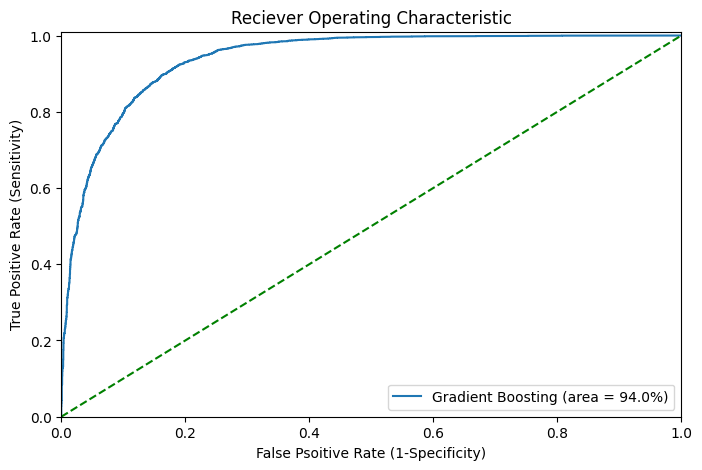

In [116]:
roc_auc = roc_auc_score(y_train_un, gb_model_un.predict_proba(X_train_un)[:,1])
fpr, tpr, thresholds = roc_curve(y_train_un, gb_model_un.predict_proba(X_train_un)[:,1])
plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label = f"Gradient Boosting (area = {round(roc_auc,2) * 100}%)")
plt.plot([0, 1], [0, 1], "g--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.01])
plt.title('Reciever Operating Characteristic')
plt.xlabel('False Psoitive Rate (1-Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(loc="lower right")
plt.show()

In [119]:
fpr, tpr,thresholds = roc_curve(y_train_un, gb_model_un.predict_proba(X_train_un)[:,1])

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold_auc_roc = thresholds[optimal_idx]
print(optimal_threshold_auc_roc)

0.4914018329553053


In [126]:
y_pred = gb_model_un.predict_proba(X_train_un)[:,1] > optimal_threshold_auc_roc
print(classification_report(y_train_un, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.84      0.86      3691
           1       0.85      0.90      0.87      3691

    accuracy                           0.87      7382
   macro avg       0.87      0.87      0.87      7382
weighted avg       0.87      0.87      0.87      7382



In [128]:
y_pred = gb_model_un.predict_proba(X_test)[:,1] > optimal_threshold_auc_roc
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     11966
           1       0.40      0.87      0.55      1598

    accuracy                           0.83     13564
   macro avg       0.69      0.85      0.72     13564
weighted avg       0.91      0.83      0.86     13564



In [130]:
importances = gb_model_un.feature_importances_
indices = np.argsort(importances)

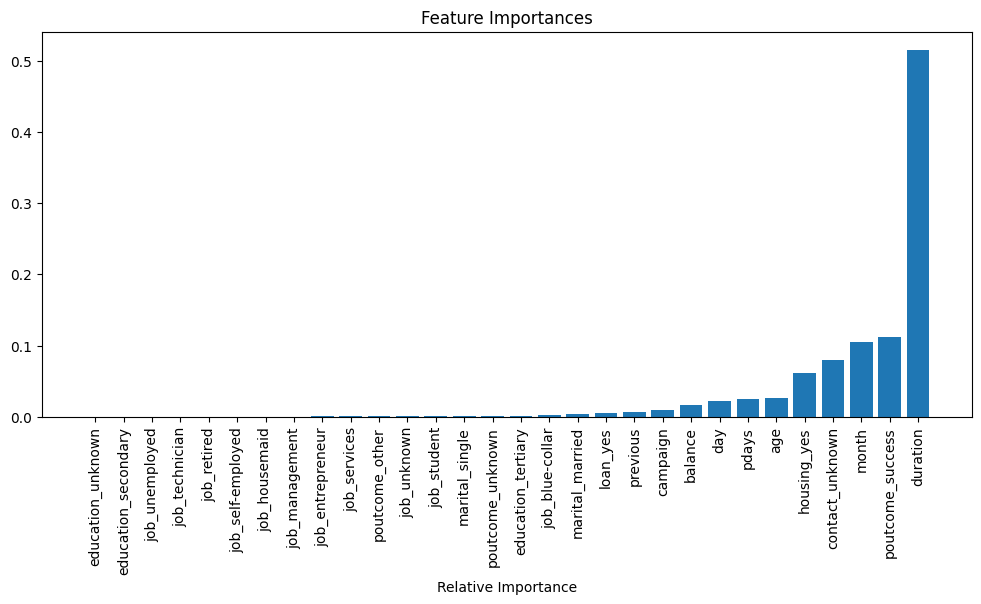

In [132]:
plt.figure(figsize=(12,5))
plt.title("Feature Importances")
plt.bar(range(len(indices)), importances[indices], align="center")
plt.xticks(range(len(indices)), [X_train.columns[i] for i in indices], rotation = 90)
plt.xlabel("Relative Importance")
plt.show()

# Observations
1. Using Randomized Search, we are not able to locate the best possible parameters as of now. We may need to increase the number of iterations or may need to use GridSearchCV.
2. We are getting better results using Undersampled data with both Random Forest and Gradient Boosting
3. The recall score of Gradient Boositing with Undersampled data is better and has very low overfitting. Therefore selecting this model would be a good choice.

# Predicted Probabilities

In [133]:
# The predicted probabilities for Gradient Boosting with undersampled data
gb_model_un.predict_proba(X_train_un)

array([[0.96415722, 0.03584278],
       [0.95225201, 0.04774799],
       [0.93530467, 0.06469533],
       ...,
       [0.14843981, 0.85156019],
       [0.18398797, 0.81601203],
       [0.1128832 , 0.8871168 ]])

In [135]:
# Stacking the arrays together and creating the DataFrame for y train
train_data = pd.DataFrame(np.stack([y_train_un, gb_model_un.predict_proba(X_train_un)[:,1]], axis = 1))

In [136]:
train_data

,0,1
0,0.0,0.035843
1,0.0,0.047748
2,0.0,0.064695
3,0.0,0.161676
4,0.0,0.035107
...,...,...
7377,1.0,0.743915
7378,1.0,0.943778
7379,1.0,0.851560
7380,1.0,0.816012


In [139]:
# Stacking the arrays together and creating the DataFrame for y test
test_data = pd.DataFrame(np.stack([y_test, gb_model_un.predict_proba(X_test)[:,1]], axis = 1))

In [140]:
test_data

,0,1
0,0.0,0.042566
1,0.0,0.049811
2,0.0,0.598291
3,0.0,0.726665
4,0.0,0.054656
...,...,...
13559,0.0,0.040002
13560,0.0,0.037885
13561,0.0,0.123576
13562,0.0,0.024454


In [141]:
train_data.columns = ['y_actual', 'y_predicted']
test_data.columns = ['y_actual', 'y_predicted']

In [143]:
test_data

,y_actual,y_predicted
0,0.0,0.042566
1,0.0,0.049811
2,0.0,0.598291
3,0.0,0.726665
4,0.0,0.054656
...,...,...
13559,0.0,0.040002
13560,0.0,0.037885
13561,0.0,0.123576
13562,0.0,0.024454


# Finding the Deciles and its Cumulative positive outcome

In [144]:
train_data['Deciles'] = pd.qcut(train_data.y_predicted, 10, labels = [10,9,8,7,6,5,4,3,2,1])
test_data['Deciles'] = pd.qcut(test_data.y_predicted, 10, labels = [10,9,8,7,6,5,4,3,2,1])

In [145]:
train_data

,y_actual,y_predicted,Deciles
0,0.0,0.035843,10
1,0.0,0.047748,9
2,0.0,0.064695,9
3,0.0,0.161676,7
4,0.0,0.035107,10
...,...,...,...
7377,1.0,0.743915,4
7378,1.0,0.943778,1
7379,1.0,0.851560,3
7380,1.0,0.816012,4


## Predicted probabilities and actual labels distribution across different deciles of the data

In [146]:
train_deciles = train_data.groupby('Deciles')[['y_predicted', 'y_actual']].agg({'y_predicted': ['min', 'max'], 
                'y_actual': ['sum', 'count']}).reset_index().sort_values(by = 'Deciles', ascending = False)

In [147]:
train_deciles

Deciles y_predicted           y_actual      
                  min       max      sum count
9       1    0.925922  0.991087    725.0   739
8       2    0.878454  0.925895    699.0   738
7       3    0.816549  0.878442    661.0   738
6       4    0.725437  0.816509    603.0   738
5       5    0.556450  0.725342    495.0   738
4       6    0.332249  0.556338    342.0   738
3       7    0.154253  0.332196    130.0   738
2       8    0.070891  0.154115     29.0   738
1       9    0.037209  0.070841      5.0   738
0      10    0.009002  0.037164      2.0   739

In [148]:
test_deciles = test_data.groupby('Deciles')[['y_predicted', 'y_actual']].agg({'y_predicted': ['min', 'max'], 
               'y_actual': ['sum', 'count']}).reset_index().sort_values(by = 'Deciles', ascending = False)

In [149]:
test_deciles

Deciles y_predicted           y_actual      
                  min       max      sum count
9       1    0.828616  0.987081    818.0  1357
8       2    0.627217  0.828575    452.0  1356
7       3    0.407609  0.627157    186.0  1355
6       4    0.250706  0.407439     83.0  1358
5       5    0.152109  0.250656     38.0  1356
4       6    0.092241  0.152024     15.0  1356
3       7    0.059513  0.092232      3.0  1356
2       8    0.041668  0.059511      1.0  1357
1       9    0.027380  0.041667      2.0  1356
0      10    0.009060  0.027371      0.0  1357

# Gain Calculation

In [151]:
train_deciles.columns = train_deciles.columns.droplevel() # Drop the level of the Dataframe (y_actual and y_predicted will be removed)

In [152]:
train_deciles.columns = ['Deciles', 'Pred_min', 'Pred_max', 'Did Term Deposit', 'Total']

In [153]:
train_deciles

,Deciles,Pred_min,Pred_max,Did Term Deposit,Total
9,1,0.925922,0.991087,725.0,739
8,2,0.878454,0.925895,699.0,738
7,3,0.816549,0.878442,661.0,738
6,4,0.725437,0.816509,603.0,738
5,5,0.556450,0.725342,495.0,738
4,6,0.332249,0.556338,342.0,738
3,7,0.154253,0.332196,130.0,738
2,8,0.070891,0.154115,29.0,738
1,9,0.037209,0.070841,5.0,738
0,10,0.009002,0.037164,2.0,739


In [161]:
train_deciles['Did Term Deposit %'] = train_deciles['Did Term Deposit'] / train_deciles['Did Term Deposit'].sum()
train_deciles['Cumulative Term Deposit %'] = np.cumsum(train_deciles['Did Term Deposit %'])

In [162]:
train_deciles

,Deciles,Pred_min,Pred_max,Did Term Deposit,Total,Did Term Deposit %,Cumulative Term deposit %,lift,Cumulative Term Deposit %
9,1,0.925922,0.991087,725.0,739,0.196424,0.196424,1.964237,0.196424
8,2,0.878454,0.925895,699.0,738,0.189380,0.385803,1.929017,0.385803
7,3,0.816549,0.878442,661.0,738,0.179084,0.564888,1.882959,0.564888
6,4,0.725437,0.816509,603.0,738,0.163370,0.728258,1.820645,0.728258
5,5,0.556450,0.725342,495.0,738,0.134110,0.862368,1.724736,0.862368
4,6,0.332249,0.556338,342.0,738,0.092658,0.955026,1.591710,0.955026
3,7,0.154253,0.332196,130.0,738,0.035221,0.990247,1.414638,0.990247
2,8,0.070891,0.154115,29.0,738,0.007857,0.998103,1.247629,0.998103
1,9,0.037209,0.070841,5.0,738,0.001355,0.999458,1.110509,0.999458
0,10,0.009002,0.037164,2.0,739,0.000542,1.000000,1.000000,1.000000


# Lift Calculation

In [165]:
train_deciles['Lift'] = train_deciles.apply(lambda x: (x['Cumulative Term Deposit %']*100) / (x['Deciles']*10), axis=1)
train_deciles

,Deciles,Pred_min,Pred_max,Did Term Deposit,Total,Did Term Deposit %,Cumulative Term deposit %,lift,Cumulative Term Deposit %,Lift
9,1,0.925922,0.991087,725.0,739,0.196424,0.196424,1.964237,0.196424,1.964237
8,2,0.878454,0.925895,699.0,738,0.189380,0.385803,1.929017,0.385803,1.929017
7,3,0.816549,0.878442,661.0,738,0.179084,0.564888,1.882959,0.564888,1.882959
6,4,0.725437,0.816509,603.0,738,0.163370,0.728258,1.820645,0.728258,1.820645
5,5,0.556450,0.725342,495.0,738,0.134110,0.862368,1.724736,0.862368,1.724736
4,6,0.332249,0.556338,342.0,738,0.092658,0.955026,1.591710,0.955026,1.591710
3,7,0.154253,0.332196,130.0,738,0.035221,0.990247,1.414638,0.990247,1.414638
2,8,0.070891,0.154115,29.0,738,0.007857,0.998103,1.247629,0.998103,1.247629
1,9,0.037209,0.070841,5.0,738,0.001355,0.999458,1.110509,0.999458,1.110509
0,10,0.009002,0.037164,2.0,739,0.000542,1.000000,1.000000,1.000000,1.000000


### Modification in Test Set

In [159]:
test_deciles.columns = test_deciles.columns.droplevel()
test_deciles.columns = ['Deciles', 'Pred_min', 'Pred_max', 'Did Term Deposit', 'Total']
test_deciles['Did Term Deposit %'] = test_deciles['Did Term Deposit'] / test_deciles['Did Term Deposit'].sum()
test_deciles['Cumulative Term Deposit %'] = np.cumsum(test_deciles['Did Term Deposit %'])
test_deciles['Lift'] = test_deciles.apply(lambda x: (x['Cumulative Term Deposit %']*100) / (x["Deciles"]*10), axis = 1)

In [160]:
test_deciles

,Deciles,Pred_min,Pred_max,Did Term Deposit,Total,Did Term Deposit %,Cumulative Term Deposit %,Lift
9,1,0.828616,0.987081,818.0,1357,0.511890,0.511890,5.118899
8,2,0.627217,0.828575,452.0,1356,0.282854,0.794743,3.973717
7,3,0.407609,0.627157,186.0,1355,0.116395,0.911139,3.037130
6,4,0.250706,0.407439,83.0,1358,0.051940,0.963079,2.407697
5,5,0.152109,0.250656,38.0,1356,0.023780,0.986859,1.973717
4,6,0.092241,0.152024,15.0,1356,0.009387,0.996245,1.660409
3,7,0.059513,0.092232,3.0,1356,0.001877,0.998123,1.425890
2,8,0.041668,0.059511,1.0,1357,0.000626,0.998748,1.248436
1,9,0.027380,0.041667,2.0,1356,0.001252,1.000000,1.111111
0,10,0.009060,0.027371,0.0,1357,0.000000,1.000000,1.000000


## Gain Curve

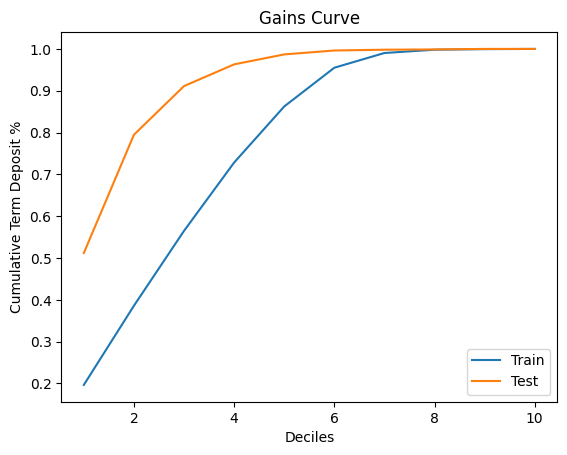

In [164]:
plt.plot(train_deciles.Deciles, train_deciles['Cumulative Term Deposit %'])
plt.plot(test_deciles.Deciles, test_deciles['Cumulative Term Deposit %'])

plt.legend(['Train', 'Test'], loc = 'lower right')
plt.xlabel('Deciles')
plt.ylabel('Cumulative Term Deposit %')
plt.title('Gains Curve')
plt.show()

## Lift Curve

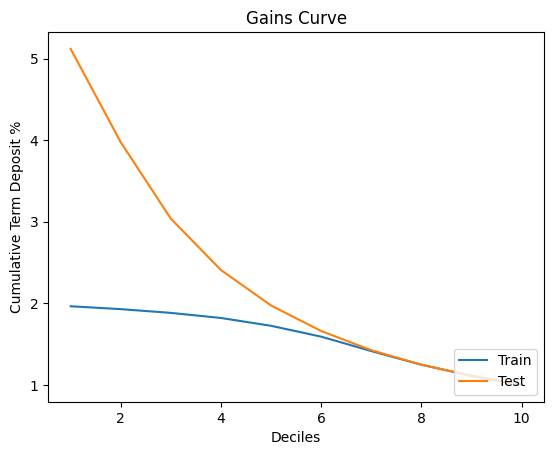

In [166]:
plt.plot(train_deciles.Deciles, train_deciles['Lift'])
plt.plot(test_deciles.Deciles, test_deciles['Lift'])

plt.legend(['Train', 'Test'], loc = 'lower right')
plt.xlabel('Deciles')
plt.ylabel('Cumulative Term Deposit %')
plt.title('Lift Curve')
plt.show()

## Observations
1. From gain and lift chart it's witnessed that our model is doing a great job in gradient boosting with undersampled data</br>
   <br> a. If we examine gains chart closely, our model is able to segregate the people making term deposits in initial deciles with high frequencies</br>
   <br> b. Similar impact can be seen via lift where we are able to witness much as 5 times more impact compared to a random model. This clearly signifies that we are able to capture good results with high recall score.</br>   